In [1]:
import sys
import os
madminer_src_path = "/home/shomiller/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals
import logging

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information, profile_information

from madminer.sampling import SampleAugmenter

from madminer.plotting import plot_distribution_of_information

from pandas import DataFrame

import madminer.__version__
print( 'MadMiner version: {}'.format(madminer.__version__) )

MadMiner version: 0.4.10


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

Formatting Options for all the Plots

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.labelsize'] = 20

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.serif'] = 'Times New Roman'

mpl.rcParams['savefig.bbox'] = 'tight'

mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['axes.formatter.use_mathtext'] = True

## Define Rotation

In [4]:
def rotate(
    fisher_info, covariance=None, include_flat_direction=False, include_nuisance_params=False, rotation_angle=None, axis1=0, axis2=1,
):

    # specify an angle (default = arctan(4), which rotates out the flat direction in cHD and cHbox)
    if rotation_angle == None:
        this_angle = np.arctan(4)
    else: 
        this_angle = rotation_angle
    
    #define the rotation matrix
    dimension = len(fisher_info)
    this_rotation_matrix = np.zeros((dimension, dimension))
    np.fill_diagonal(this_rotation_matrix, 1)
    this_rotation_matrix[axis1,axis1] = np.cos(this_angle)
    this_rotation_matrix[axis1,axis2] = -1.*np.sin(this_angle)
    this_rotation_matrix[axis2,axis1] =  1.*np.sin(this_angle)
    this_rotation_matrix[axis2,axis2] = np.cos(this_angle)
    
    #get the rotated fisher information
    rotated_fisher_info = np.einsum('ki,lj,kl->ij', this_rotation_matrix, this_rotation_matrix, fisher_info)
    
    #get the rotated covariance of the fisher information
    if covariance is None:
        rotated_covariance = covariance 
    else:
        rotated_covariance = np.einsum('mi,nj,ok,pl,mnop->ijkl', 
                                this_rotation_matrix, this_rotation_matrix, this_rotation_matrix, this_rotation_matrix, covariance)

    # If not desired, project out the nuisance parameters
    if not include_nuisance_params:
        if covariance is None:
            rotated_fisher_info = project_information(rotated_fisher_info, [0,1,2,3])
        else:
            rotated_fisher_info, rotated_covariance = project_information(rotated_fisher_info, [0,1,2,3], covariance=rotated_covariance)
        
    #return either the three physical directions or include the flat direction
    if include_flat_direction:
        if covariance is None:
            return rotated_fisher_info
        else:
            return rotated_fisher_info, rotated_covariance
    else:
        return project_information(rotated_fisher_info, np.arange(1,len(rotated_fisher_info)), covariance=rotated_covariance)

# Load Data for Plots

## Load the Signal & Background Samples

In [5]:
sa_sig_wph_mu = SampleAugmenter('data/met/signal/wph_mu_smeftsim_lhedata_met.h5')
x_weighted_sig_wph_mu, weights_sig_wph_mu = sa_sig_wph_mu.weighted_events(theta=[0.,0.,0.,0.])

sa_bkgs_wph_mu = SampleAugmenter('data/met/wph_mu_backgrounds_only_lhedata_met.h5')
x_weighted_bkg_wph_mu, weights_bkg_wph_mu = sa_bkgs_wph_mu.weighted_events(theta=[0.,0.,0.,0.])

20:40 madminer.analysis    INFO    Loading data from data/met/signal/wph_mu_smeftsim_lhedata_met.h5
20:40 madminer.analysis    INFO    Found 4 parameters
20:40 madminer.analysis    INFO    Found 33 nuisance parameters
20:40 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:40 madminer.analysis    INFO    Found 48 observables
20:40 madminer.analysis    INFO    Found 1000000 events
20:40 madminer.analysis    INFO      1000000 signal events sampled from benchmark sm
20:40 madminer.analysis    INFO    Found morphing setup with 15 components
20:40 madminer.analysis    INFO    Found nuisance morphing setup
20:40 madminer.analysis    INFO    Loading data from data/met/wph_mu_backgrounds_only_lhedata_met.h5
20:40 madminer.analysis    INFO    Found 4 parameters
20:40 madminer.analysis    INFO    Found 33 nuisance parameters
20:40 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:40 madminer.analysis    INFO    Found 48 observables
20:40 madminer.a

In [6]:
sa_sig_wph_e = SampleAugmenter('data/met/signal/wph_e_smeftsim_lhedata_met.h5')
x_weighted_sig_wph_e, weights_sig_wph_e = sa_sig_wph_e.weighted_events(theta=[0.,0.,0.,0.])

sa_bkgs_wph_e = SampleAugmenter('data/met/wph_e_backgrounds_only_lhedata_met.h5')
x_weighted_bkg_wph_e, weights_bkg_wph_e = sa_bkgs_wph_e.weighted_events(theta=[0.,0.,0.,0.])

20:40 madminer.analysis    INFO    Loading data from data/met/signal/wph_e_smeftsim_lhedata_met.h5
20:40 madminer.analysis    INFO    Found 4 parameters
20:40 madminer.analysis    INFO    Found 33 nuisance parameters
20:40 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:40 madminer.analysis    INFO    Found 48 observables
20:40 madminer.analysis    INFO    Found 1000000 events
20:40 madminer.analysis    INFO      1000000 signal events sampled from benchmark sm
20:40 madminer.analysis    INFO    Found morphing setup with 15 components
20:40 madminer.analysis    INFO    Found nuisance morphing setup
20:40 madminer.analysis    INFO    Loading data from data/met/wph_e_backgrounds_only_lhedata_met.h5
20:40 madminer.analysis    INFO    Found 4 parameters
20:40 madminer.analysis    INFO    Found 33 nuisance parameters
20:40 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:40 madminer.analysis    INFO    Found 48 observables
20:40 madminer.ana

In [7]:
sa_sig_wmh_mu = SampleAugmenter('data/met/signal/wmh_mu_smeftsim_lhedata_met.h5')
x_weighted_sig_wmh_mu, weights_sig_wmh_mu = sa_sig_wmh_mu.weighted_events(theta=[0.,0.,0.,0.])

sa_bkgs_wmh_mu = SampleAugmenter('data/met/wmh_mu_backgrounds_only_lhedata_met.h5')
x_weighted_bkg_wmh_mu, weights_bkg_wmh_mu = sa_bkgs_wmh_mu.weighted_events(theta=[0.,0.,0.,0.])

20:41 madminer.analysis    INFO    Loading data from data/met/signal/wmh_mu_smeftsim_lhedata_met.h5
20:41 madminer.analysis    INFO    Found 4 parameters
20:41 madminer.analysis    INFO    Found 33 nuisance parameters
20:41 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:41 madminer.analysis    INFO    Found 48 observables
20:41 madminer.analysis    INFO    Found 1000000 events
20:41 madminer.analysis    INFO      1000000 signal events sampled from benchmark sm
20:41 madminer.analysis    INFO    Found morphing setup with 15 components
20:41 madminer.analysis    INFO    Found nuisance morphing setup
20:41 madminer.analysis    INFO    Loading data from data/met/wmh_mu_backgrounds_only_lhedata_met.h5
20:41 madminer.analysis    INFO    Found 4 parameters
20:41 madminer.analysis    INFO    Found 33 nuisance parameters
20:41 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:41 madminer.analysis    INFO    Found 48 observables
20:41 madminer.a

In [8]:
sa_sig_wmh_e = SampleAugmenter('data/met/signal/wmh_e_smeftsim_lhedata_met.h5')
x_weighted_sig_wmh_e, weights_sig_wmh_e = sa_sig_wmh_e.weighted_events(theta=[0.,0.,0.,0.])

sa_bkgs_wmh_e = SampleAugmenter('data/met/wmh_e_backgrounds_only_lhedata_met.h5')
x_weighted_bkg_wmh_e, weights_bkg_wmh_e = sa_bkgs_wmh_e.weighted_events(theta=[0.,0.,0.,0.])

20:41 madminer.analysis    INFO    Loading data from data/met/signal/wmh_e_smeftsim_lhedata_met.h5
20:41 madminer.analysis    INFO    Found 4 parameters
20:41 madminer.analysis    INFO    Found 33 nuisance parameters
20:41 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:41 madminer.analysis    INFO    Found 48 observables
20:41 madminer.analysis    INFO    Found 1000000 events
20:41 madminer.analysis    INFO      1000000 signal events sampled from benchmark sm
20:41 madminer.analysis    INFO    Found morphing setup with 15 components
20:41 madminer.analysis    INFO    Found nuisance morphing setup
20:41 madminer.analysis    INFO    Loading data from data/met/wmh_e_backgrounds_only_lhedata_met.h5
20:41 madminer.analysis    INFO    Found 4 parameters
20:41 madminer.analysis    INFO    Found 33 nuisance parameters
20:41 madminer.analysis    INFO    Found 54 benchmarks, of which 15 physical
20:41 madminer.analysis    INFO    Found 48 observables
20:41 madminer.ana

Combine for Plotting

In [9]:
x_weighted_sig = np.concatenate((x_weighted_sig_wph_mu, x_weighted_sig_wph_e, x_weighted_sig_wmh_mu, x_weighted_sig_wmh_e))
weights_sig = np.concatenate((weights_sig_wph_mu, weights_sig_wph_e, weights_sig_wmh_mu, weights_sig_wmh_e))
x_weighted_bkg = np.concatenate((x_weighted_bkg_wph_mu, x_weighted_bkg_wph_e, x_weighted_bkg_wmh_mu, x_weighted_bkg_wmh_e))
weights_bkg = np.concatenate((weights_bkg_wph_mu, weights_bkg_wph_e, weights_bkg_wmh_mu, weights_bkg_wmh_e))

## Load the Distribution Data

### The Normal (Truncated) Results

#### $p_{T,W}$

In [11]:
fi_histo_ptw_outfile = './fisher_info/dists/fi_histo_ptw.npz'

bins_histo_wph_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][0]
w_in_histo_wph_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][2]
fi_histo_wph_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][3]
bins_histo_wph_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][4]
w_in_histo_wph_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][5]
fi_histo_rate_wph_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][6]
fi_histo_wph_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][7]
bins_histo_wmh_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][8]
w_in_histo_wmh_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][10]
fi_histo_wmh_mu_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][11]
bins_histo_wmh_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][12]
w_in_histo_wmh_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][14]
fi_histo_wmh_e_ptw= np.load(fi_histo_ptw_outfile)['arr_0'][15]

In [12]:
fi_histo_rate_ptw= [ fi_histo_rate_wph_mu_ptw[i]
                     + fi_histo_rate_wph_e_ptw[i] 
                     + fi_histo_rate_wmh_mu_ptw[i] 
                     + fi_histo_rate_wmh_e_ptw[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_ptw)) ]

fi_histo_ptw= [ fi_histo_wph_mu_ptw[i]
                     + fi_histo_wph_e_ptw[i] 
                     + fi_histo_wmh_mu_ptw[i] 
                     + fi_histo_wmh_e_ptw[i] 
                     for i in range(0, len(fi_histo_wph_mu_ptw)) ]

fi_histo_rate_ptw_rot = [ rotate(fi_histo_rate_ptw[i]) for i in range(0, len(fi_histo_rate_ptw)) ]
fi_histo_ptw_rot = [ rotate(fi_histo_ptw[i]) for i in range(0, len(fi_histo_ptw)) ]

#### $m_{T,\mathrm{tot}}$

In [13]:
fi_histo_mttot_outfile = './fisher_info/dists/fi_histo_mttot.npz'

bins_histo_wph_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][0]
w_in_histo_wph_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][2]
fi_histo_wph_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][3]
bins_histo_wph_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][4]
w_in_histo_wph_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][5]
fi_histo_rate_wph_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][6]
fi_histo_wph_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][7]
bins_histo_wmh_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][8]
w_in_histo_wmh_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][10]
fi_histo_wmh_mu_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][11]
bins_histo_wmh_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][12]
w_in_histo_wmh_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][14]
fi_histo_wmh_e_mttot= np.load(fi_histo_mttot_outfile)['arr_0'][15]

In [14]:
fi_histo_rate_mttot= [ fi_histo_rate_wph_mu_mttot[i]
                     + fi_histo_rate_wph_e_mttot[i] 
                     + fi_histo_rate_wmh_mu_mttot[i] 
                     + fi_histo_rate_wmh_e_mttot[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_mttot)) ]

fi_histo_mttot= [ fi_histo_wph_mu_mttot[i]
                     + fi_histo_wph_e_mttot[i] 
                     + fi_histo_wmh_mu_mttot[i] 
                     + fi_histo_wmh_e_mttot[i] 
                     for i in range(0, len(fi_histo_wph_mu_mttot)) ]

fi_histo_rate_mttot_rot = [ rotate(fi_histo_rate_mttot[i]) for i in range(0, len(fi_histo_rate_mttot)) ]
fi_histo_mttot_rot = [ rotate(fi_histo_mttot[i]) for i in range(0, len(fi_histo_mttot)) ]

#### $\eta_h$

In [15]:
fi_histo_etah_outfile = './fisher_info/dists/fi_histo_etah.npz'

bins_histo_wph_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][0]
w_in_histo_wph_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][2]
fi_histo_wph_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][3]
bins_histo_wph_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][4]
w_in_histo_wph_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][5]
fi_histo_rate_wph_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][6]
fi_histo_wph_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][7]
bins_histo_wmh_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][8]
w_in_histo_wmh_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][10]
fi_histo_wmh_mu_etah= np.load(fi_histo_etah_outfile)['arr_0'][11]
bins_histo_wmh_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][12]
w_in_histo_wmh_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][14]
fi_histo_wmh_e_etah= np.load(fi_histo_etah_outfile)['arr_0'][15]

In [16]:
fi_histo_rate_etah= [ fi_histo_rate_wph_mu_etah[i]
                     + fi_histo_rate_wph_e_etah[i] 
                     + fi_histo_rate_wmh_mu_etah[i] 
                     + fi_histo_rate_wmh_e_etah[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_etah)) ]

fi_histo_etah= [ fi_histo_wph_mu_etah[i]
                     + fi_histo_wph_e_etah[i] 
                     + fi_histo_wmh_mu_etah[i] 
                     + fi_histo_wmh_e_etah[i] 
                     for i in range(0, len(fi_histo_wph_mu_etah)) ]

fi_histo_rate_etah_rot = [ rotate(fi_histo_rate_etah[i]) for i in range(0, len(fi_histo_rate_etah)) ]
fi_histo_etah_rot = [ rotate(fi_histo_etah[i]) for i in range(0, len(fi_histo_etah)) ]

#### $\Delta R_{\ell b_1}$

In [17]:
fi_histo_drlb1_outfile = './fisher_info/dists/fi_histo_drlb1.npz'

bins_histo_wph_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][0]
w_in_histo_wph_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][2]
fi_histo_wph_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][3]
bins_histo_wph_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][4]
w_in_histo_wph_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][5]
fi_histo_rate_wph_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][6]
fi_histo_wph_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][7]
bins_histo_wmh_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][8]
w_in_histo_wmh_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][10]
fi_histo_wmh_mu_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][11]
bins_histo_wmh_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][12]
w_in_histo_wmh_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][14]
fi_histo_wmh_e_drlb1= np.load(fi_histo_drlb1_outfile)['arr_0'][15]

In [18]:
fi_histo_rate_drlb1= [ fi_histo_rate_wph_mu_drlb1[i]
                     + fi_histo_rate_wph_e_drlb1[i] 
                     + fi_histo_rate_wmh_mu_drlb1[i] 
                     + fi_histo_rate_wmh_e_drlb1[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_drlb1)) ]

fi_histo_drlb1= [ fi_histo_wph_mu_drlb1[i]
                     + fi_histo_wph_e_drlb1[i] 
                     + fi_histo_wmh_mu_drlb1[i] 
                     + fi_histo_wmh_e_drlb1[i] 
                     for i in range(0, len(fi_histo_wph_mu_drlb1)) ]

fi_histo_rate_drlb1_rot = [ rotate(fi_histo_rate_drlb1[i]) for i in range(0, len(fi_histo_rate_drlb1)) ]
fi_histo_drlb1_rot = [ rotate(fi_histo_drlb1[i]) for i in range(0, len(fi_histo_drlb1)) ]

### The (dim6)^2 Results

#### $p_{T,W}$

In [19]:
fi_histo_ptw_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_ptw_d62.npz'

bins_histo_wph_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][3]
bins_histo_wph_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][6]
fi_histo_wph_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_ptw_d62= np.load(fi_histo_ptw_d62_outfile)['arr_0'][15]

In [20]:
fi_histo_rate_ptw_d62= [ fi_histo_rate_wph_mu_ptw_d62[i]
                     + fi_histo_rate_wph_e_ptw_d62[i] 
                     + fi_histo_rate_wmh_mu_ptw_d62[i] 
                     + fi_histo_rate_wmh_e_ptw_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_ptw_d62)) ]

fi_histo_ptw_d62= [ fi_histo_wph_mu_ptw_d62[i]
                     + fi_histo_wph_e_ptw_d62[i] 
                     + fi_histo_wmh_mu_ptw_d62[i] 
                     + fi_histo_wmh_e_ptw_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_ptw_d62)) ]

fi_histo_rate_ptw_d62_rot = [ rotate(fi_histo_rate_ptw_d62[i]) for i in range(0, len(fi_histo_rate_ptw_d62)) ]
fi_histo_ptw_d62_rot = [ rotate(fi_histo_ptw_d62[i]) for i in range(0, len(fi_histo_ptw_d62)) ]

#### $m_{T,\mathrm{tot}}$

In [21]:
fi_histo_mttot_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_mttot_d62.npz'

bins_histo_wph_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][3]
bins_histo_wph_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][6]
fi_histo_wph_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_mttot_d62= np.load(fi_histo_mttot_d62_outfile)['arr_0'][15]

In [22]:
fi_histo_rate_mttot_d62= [ fi_histo_rate_wph_mu_mttot_d62[i]
                     + fi_histo_rate_wph_e_mttot_d62[i] 
                     + fi_histo_rate_wmh_mu_mttot_d62[i] 
                     + fi_histo_rate_wmh_e_mttot_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_mttot_d62)) ]

fi_histo_mttot_d62= [ fi_histo_wph_mu_mttot_d62[i]
                     + fi_histo_wph_e_mttot_d62[i] 
                     + fi_histo_wmh_mu_mttot_d62[i] 
                     + fi_histo_wmh_e_mttot_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_mttot_d62)) ]

fi_histo_rate_mttot_d62_rot = [ rotate(fi_histo_rate_mttot_d62[i]) for i in range(0, len(fi_histo_rate_mttot_d62)) ]
fi_histo_mttot_d62_rot = [ rotate(fi_histo_mttot_d62[i]) for i in range(0, len(fi_histo_mttot_d62)) ]

#### $\eta_h$

In [23]:
fi_histo_etah_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_etah_d62.npz'

bins_histo_wph_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][3]
bins_histo_wph_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][6]
fi_histo_wph_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_etah_d62= np.load(fi_histo_etah_d62_outfile)['arr_0'][15]

In [24]:
fi_histo_rate_etah_d62= [ fi_histo_rate_wph_mu_etah_d62[i]
                     + fi_histo_rate_wph_e_etah_d62[i] 
                     + fi_histo_rate_wmh_mu_etah_d62[i] 
                     + fi_histo_rate_wmh_e_etah_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_etah_d62)) ]

fi_histo_etah_d62= [ fi_histo_wph_mu_etah_d62[i]
                     + fi_histo_wph_e_etah_d62[i] 
                     + fi_histo_wmh_mu_etah_d62[i] 
                     + fi_histo_wmh_e_etah_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_etah_d62)) ]

fi_histo_rate_etah_d62_rot = [ rotate(fi_histo_rate_etah_d62[i]) for i in range(0, len(fi_histo_rate_etah_d62)) ]
fi_histo_etah_d62_rot = [ rotate(fi_histo_etah_d62[i]) for i in range(0, len(fi_histo_etah_d62)) ]

#### $\Delta R_{\ell b_1}$

In [25]:
fi_histo_drlb1_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_drlb1_d62.npz'

bins_histo_wph_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][3]
bins_histo_wph_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][6]
fi_histo_wph_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_drlb1_d62= np.load(fi_histo_drlb1_d62_outfile)['arr_0'][15]

In [26]:
fi_histo_rate_drlb1_d62= [ fi_histo_rate_wph_mu_drlb1_d62[i]
                     + fi_histo_rate_wph_e_drlb1_d62[i] 
                     + fi_histo_rate_wmh_mu_drlb1_d62[i] 
                     + fi_histo_rate_wmh_e_drlb1_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_drlb1_d62)) ]

fi_histo_drlb1_d62= [ fi_histo_wph_mu_drlb1_d62[i]
                     + fi_histo_wph_e_drlb1_d62[i] 
                     + fi_histo_wmh_mu_drlb1_d62[i] 
                     + fi_histo_wmh_e_drlb1_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_drlb1_d62)) ]

fi_histo_rate_drlb1_d62_rot = [ rotate(fi_histo_rate_drlb1_d62[i]) for i in range(0, len(fi_histo_rate_drlb1_d62)) ]
fi_histo_drlb1_d62_rot = [ rotate(fi_histo_drlb1_d62[i]) for i in range(0, len(fi_histo_drlb1_d62)) ]

### Import the Signal Only Results

#### Linearized Results

In [10]:
fi_histo_nobkgs_ptw_outfile = './fisher_info/dists/fi_histo_nobkgs_ptw.npz'

bins_histo_wph_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][0]
w_in_histo_wph_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][2]
fi_histo_wph_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][3]
bins_histo_wph_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][4]
w_in_histo_wph_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][5]
fi_histo_rate_wph_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][6]
fi_histo_wph_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][7]
bins_histo_wmh_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][8]
w_in_histo_wmh_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][10]
fi_histo_wmh_mu_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][11]
bins_histo_wmh_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][12]
w_in_histo_wmh_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][14]
fi_histo_wmh_e_nobkgs_ptw= np.load(fi_histo_nobkgs_ptw_outfile)['arr_0'][15]

In [11]:
fi_histo_rate_nobkgs_ptw= [ fi_histo_rate_wph_mu_nobkgs_ptw[i]
                     + fi_histo_rate_wph_e_nobkgs_ptw[i] 
                     + fi_histo_rate_wmh_mu_nobkgs_ptw[i] 
                     + fi_histo_rate_wmh_e_nobkgs_ptw[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_nobkgs_ptw)) ]

fi_histo_nobkgs_ptw= [ fi_histo_wph_mu_nobkgs_ptw[i]
                     + fi_histo_wph_e_nobkgs_ptw[i] 
                     + fi_histo_wmh_mu_nobkgs_ptw[i] 
                     + fi_histo_wmh_e_nobkgs_ptw[i] 
                     for i in range(0, len(fi_histo_wph_mu_nobkgs_ptw)) ]

fi_histo_rate_nobkgs_ptw_rot = [ rotate(fi_histo_rate_nobkgs_ptw[i]) for i in range(0, len(fi_histo_rate_nobkgs_ptw)) ]
fi_histo_nobkgs_ptw_rot = [ rotate(fi_histo_nobkgs_ptw[i]) for i in range(0, len(fi_histo_nobkgs_ptw)) ]

In [13]:
fi_histo_nobkgs_mttot_outfile = './fisher_info/dists/fi_histo_nobkgs_mttot.npz'

bins_histo_wph_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][0]
w_in_histo_wph_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][2]
fi_histo_wph_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][3]
bins_histo_wph_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][4]
w_in_histo_wph_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][5]
fi_histo_rate_wph_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][6]
fi_histo_wph_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][7]
bins_histo_wmh_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][8]
w_in_histo_wmh_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][10]
fi_histo_wmh_mu_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][11]
bins_histo_wmh_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][12]
w_in_histo_wmh_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][14]
fi_histo_wmh_e_nobkgs_mttot= np.load(fi_histo_nobkgs_mttot_outfile)['arr_0'][15]

In [14]:
fi_histo_rate_nobkgs_mttot= [ fi_histo_rate_wph_mu_nobkgs_mttot[i]
                     + fi_histo_rate_wph_e_nobkgs_mttot[i] 
                     + fi_histo_rate_wmh_mu_nobkgs_mttot[i] 
                     + fi_histo_rate_wmh_e_nobkgs_mttot[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_nobkgs_mttot)) ]

fi_histo_nobkgs_mttot= [ fi_histo_wph_mu_nobkgs_mttot[i]
                     + fi_histo_wph_e_nobkgs_mttot[i] 
                     + fi_histo_wmh_mu_nobkgs_mttot[i] 
                     + fi_histo_wmh_e_nobkgs_mttot[i] 
                     for i in range(0, len(fi_histo_wph_mu_nobkgs_mttot)) ]

fi_histo_rate_nobkgs_mttot_rot = [ rotate(fi_histo_rate_nobkgs_mttot[i]) for i in range(0, len(fi_histo_rate_nobkgs_mttot)) ]
fi_histo_nobkgs_mttot_rot = [ rotate(fi_histo_nobkgs_mttot[i]) for i in range(0, len(fi_histo_nobkgs_mttot)) ]

#### dim6-squared results

In [15]:
fi_histo_nobkgs_ptw_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_nobkgs_ptw_d62.npz'

bins_histo_wph_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][3]
bins_histo_wph_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][6]
fi_histo_wph_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_nobkgs_ptw_d62= np.load(fi_histo_nobkgs_ptw_d62_outfile)['arr_0'][15]

In [16]:
fi_histo_rate_nobkgs_ptw_d62= [ fi_histo_rate_wph_mu_nobkgs_ptw_d62[i]
                     + fi_histo_rate_wph_e_nobkgs_ptw_d62[i] 
                     + fi_histo_rate_wmh_mu_nobkgs_ptw_d62[i] 
                     + fi_histo_rate_wmh_e_nobkgs_ptw_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_nobkgs_ptw_d62)) ]

fi_histo_nobkgs_ptw_d62= [ fi_histo_wph_mu_nobkgs_ptw_d62[i]
                     + fi_histo_wph_e_nobkgs_ptw_d62[i] 
                     + fi_histo_wmh_mu_nobkgs_ptw_d62[i] 
                     + fi_histo_wmh_e_nobkgs_ptw_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_nobkgs_ptw_d62)) ]

fi_histo_rate_nobkgs_ptw_d62_rot = [ rotate(fi_histo_rate_nobkgs_ptw_d62[i]) for i in range(0, len(fi_histo_rate_nobkgs_ptw_d62)) ]
fi_histo_nobkgs_ptw_d62_rot = [ rotate(fi_histo_nobkgs_ptw_d62[i]) for i in range(0, len(fi_histo_nobkgs_ptw_d62)) ]

In [17]:
fi_histo_nobkgs_mttot_d62_outfile = './dim6_squared_results/fisher_info/dists/fi_histo_nobkgs_mttot_d62.npz'

bins_histo_wph_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][0]
w_in_histo_wph_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][1]
fi_histo_rate_wph_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][2]
fi_histo_wph_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][3]
bins_histo_wph_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][4]
w_in_histo_wph_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][5]
fi_histo_rate_wph_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][6]
fi_histo_wph_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][7]
bins_histo_wmh_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][8]
w_in_histo_wmh_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][9]
fi_histo_rate_wmh_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][10]
fi_histo_wmh_mu_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][11]
bins_histo_wmh_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][12]
w_in_histo_wmh_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][13]
fi_histo_rate_wmh_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][14]
fi_histo_wmh_e_nobkgs_mttot_d62= np.load(fi_histo_nobkgs_mttot_d62_outfile)['arr_0'][15]

In [18]:
fi_histo_rate_nobkgs_mttot_d62= [ fi_histo_rate_wph_mu_nobkgs_mttot_d62[i]
                     + fi_histo_rate_wph_e_nobkgs_mttot_d62[i] 
                     + fi_histo_rate_wmh_mu_nobkgs_mttot_d62[i] 
                     + fi_histo_rate_wmh_e_nobkgs_mttot_d62[i] 
                     for i in range(0, len(fi_histo_rate_wph_mu_nobkgs_mttot_d62)) ]

fi_histo_nobkgs_mttot_d62= [ fi_histo_wph_mu_nobkgs_mttot_d62[i]
                     + fi_histo_wph_e_nobkgs_mttot_d62[i] 
                     + fi_histo_wmh_mu_nobkgs_mttot_d62[i] 
                     + fi_histo_wmh_e_nobkgs_mttot_d62[i] 
                     for i in range(0, len(fi_histo_wph_mu_nobkgs_mttot_d62)) ]

fi_histo_rate_nobkgs_mttot_d62_rot = [ rotate(fi_histo_rate_nobkgs_mttot_d62[i]) for i in range(0, len(fi_histo_rate_nobkgs_mttot_d62)) ]
fi_histo_nobkgs_mttot_d62_rot = [ rotate(fi_histo_nobkgs_mttot_d62[i]) for i in range(0, len(fi_histo_nobkgs_mttot_d62)) ]

# Make the Plots

## Make the (Linearized) Plots

### Legend Definitions

In [25]:
color_sig = 'gold'
color_bkg = '#DCDCDC'

fi_dist_color1 = 'blue'
fi_dist_linestyle1 = 'solid'
fi_dist_color2 = 'red'
fi_dist_linestyle2 = 'dotted'
fi_dist_color3 = 'green'
fi_dist_linestyle3 = 'dashed'

fi_dist_linewidth = 2

In [32]:
legend_elements = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls='solid',
           label=r'$\tilde{C}_{HD}$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{HW}$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{Hq}^{(3)}$'),
        Patch(facecolor=color_sig, label='SM $WH$'),
        Patch(facecolor=color_bkg, label='QCD Backgrounds')
    ]

In [33]:
legend_elements_short = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls='solid',
           label=r'$\tilde{C}_{HD}$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{HW}$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{Hq}^{(3)}$'),
        Patch(facecolor=color_sig, label='SM $WH$'),
        Patch(facecolor=color_bkg, label='QCD')
    ]

In [34]:
legend_elements_split1 = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls='solid',
           label=r'$\tilde{C}_{HD}$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{HW}$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls='solid',
           label=r'$C_{Hq}^{(3)}$'),
]

legend_elements_split2 = [
        Patch(facecolor=color_sig, label='SM $WH$'),
        Patch(facecolor=color_bkg, label='QCD')
]

### Make the Plots

In [36]:
def distribution_plot(bins, observable, xlabel, fi_list, outfilename, log_y_axis=True, include_legend=True, legend_loc='upper right', my_xrange=None):

#    bins_ptw = bins_histo_wph_mu_ptw
    xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
    xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
    if my_xrange is not None:
        thisrange = my_xrange
    else:
        thisrange = (bins[0], bins[-1])

    index = sa_bkgs_wph_mu.observables.keys().index(observable)
    #x_weighted_bkg[:,thisindex]

    fig = plt.figure(figsize=(8,6))
    ax1 = plt.subplot(111)
    fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

    ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
    ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
    ax1.set_xlim(my_xrange)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
    ax1.hist(
        [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
        weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
        bins = bins,
        range = thisrange,
        histtype='stepfilled',
        stacked=True,
        color=[color_bkg, color_sig],
        alpha=1.0
    )

    if log_y_axis:
        ax1.set_yscale('log')

    ## Second Axis for F.I.

    ax2 = ax1.twinx()
    ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

    fi1_norm = sum([fi[0,0] for fi in fi_list])
    fi2_norm = sum([fi[1,1] for fi in fi_list])
    fi3_norm = sum([fi[2,2] for fi in fi_list])

    ax2.hist(
        xvals,
        weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color1,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle1,
        label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
    )

    ax2.hist(
        xvals,
        weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color2,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle2,
        label=r'$c_{HW}$'
    )

    ax2.hist(
        xvals,
        weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color3,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle3,
        label=r'$c_{Hq}^{(3)}$'
    )

    if include_legend:
        ax2.legend(handles=legend_elements, loc=legend_loc, fontsize=16, frameon=False)
        
    plt.tight_layout()
    plt.savefig('plots/dists/{}.pdf'.format(outfilename))
    plt.show()

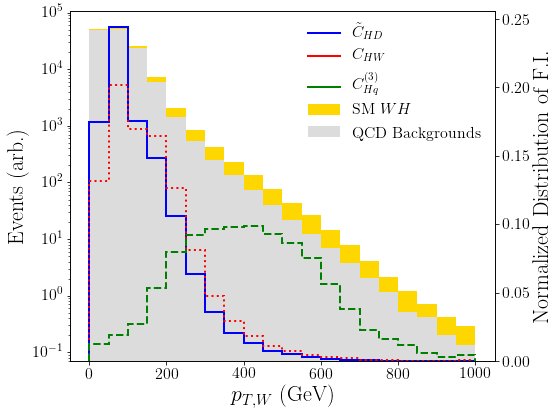

In [37]:
distribution_plot(bins_histo_wph_mu_ptw, 'pt_w', r'$p_{T,W}$ (GeV)', fi_histo_ptw_rot, 'info_dist_ptw')

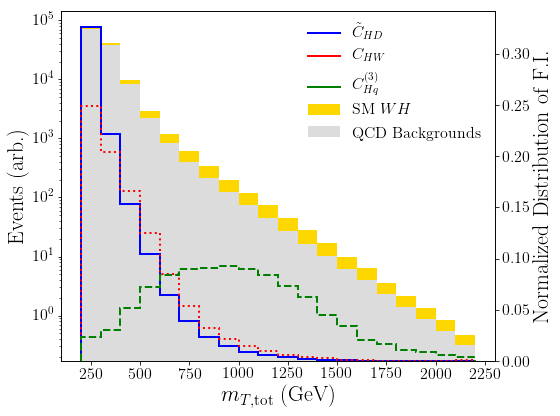

In [38]:
distribution_plot(bins_histo_wph_mu_mttot, 'mt_tot',r'$m_{T,\mathrm{tot}}$ (GeV)', fi_histo_mttot_rot, 'info_dist_mttot')

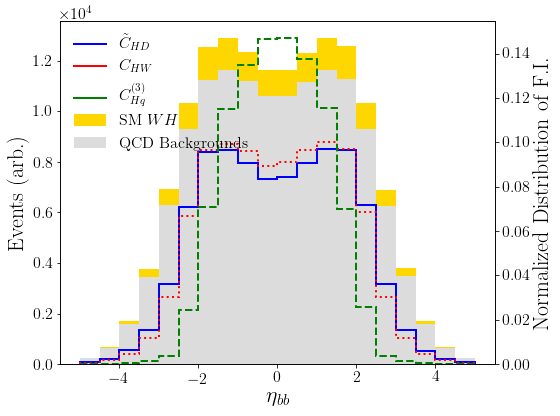

In [39]:
distribution_plot(bins_histo_wph_mu_etah, 'eta_h', r'$\eta_{bb}$', fi_histo_etah_rot, 'info_dist_etah', log_y_axis=False, legend_loc='upper left')

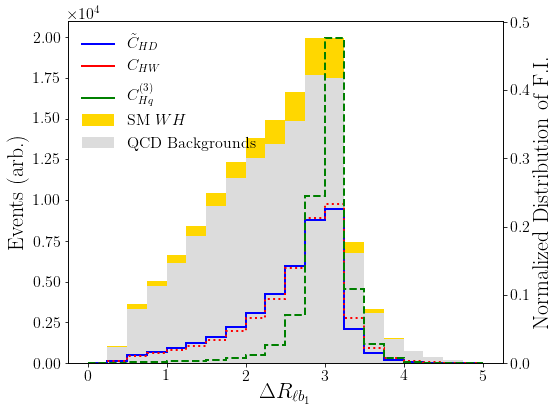

In [40]:
distribution_plot(bins_histo_wph_mu_drlb1, 'dR_lb1', r'$\Delta R_{\ell b_1}$', fi_histo_drlb1_rot, 'info_dist_drlb1', log_y_axis=False, legend_loc='upper left')

## Make the d6^2 Plots

In [41]:
legend_elements_d62 = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls='solid',
           label=r'$(\tilde{C}_{HD})^2$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls='solid',
           label=r'$(C_{HW})^2$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls='solid',
           label=r'$(C_{Hq}^{(3)})^2$'),
        Patch(facecolor=color_sig, label='SM $WH$'),
        Patch(facecolor=color_bkg, label='QCD Backgrounds')
    ]

In [42]:
def d62_distribution_plot(bins, observable, xlabel, fi_list, outfilename, log_y_axis=True, include_legend=True, legend_loc='upper right', my_xrange=None):

#    bins_ptw = bins_histo_wph_mu_ptw
    xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
    xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
    if my_xrange is not None:
        thisrange = my_xrange
    else:
        thisrange = (bins[0], bins[-1])

    index = sa_bkgs_wph_mu.observables.keys().index(observable)
    #x_weighted_bkg[:,thisindex]

    fig = plt.figure(figsize=(8,6))
    ax1 = plt.subplot(111)
    fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

    ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
    ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
    ax1.set_xlim(my_xrange)
    ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
    ax1.hist(
        [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
        weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
        bins = bins,
        range = thisrange,
        histtype='stepfilled',
        stacked=True,
        color=[color_bkg, color_sig],
        alpha=1.0
    )

    if log_y_axis:
        ax1.set_yscale('log')

    ## Second Axis for F.I.

    ax2 = ax1.twinx()
    ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

    fi1_norm = sum([fi[0,0] for fi in fi_list])
    fi2_norm = sum([fi[1,1] for fi in fi_list])
    fi3_norm = sum([fi[2,2] for fi in fi_list])

    ax2.hist(
        xvals,
        weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color1,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle1,
        label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
    )

    ax2.hist(
        xvals,
        weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color2,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle2,
        label=r'$c_{HW}$'
    )

    ax2.hist(
        xvals,
        weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
        bins = bins,
        range = thisrange,
        histtype = 'step',
        color = fi_dist_color3,
        linewidth = fi_dist_linewidth,
        linestyle = fi_dist_linestyle3,
        label=r'$c_{Hq}^{(3)}$'
    )

    if include_legend:
        ax2.legend(handles=legend_elements_d62, loc=legend_loc, fontsize=16, frameon=False)
        
    plt.tight_layout()
    plt.savefig('dim6_squared_results/plots/{}.pdf'.format(outfilename))
    plt.show()

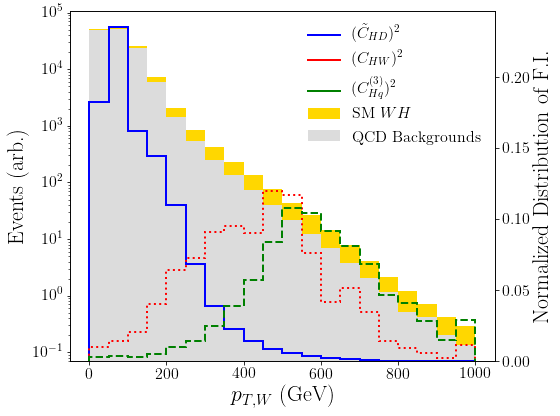

In [43]:
d62_distribution_plot(bins_histo_wph_mu_ptw_d62, 'pt_w', r'$p_{T,W}$ (GeV)', fi_histo_ptw_d62_rot, 'd62_info_dist_ptw')

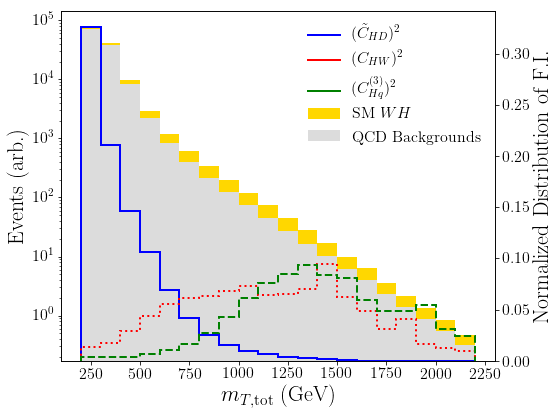

In [44]:
d62_distribution_plot(bins_histo_wph_mu_mttot_d62, 'mt_tot',r'$m_{T,\mathrm{tot}}$ (GeV)', fi_histo_mttot_d62_rot, 'd62_info_dist_mttot')

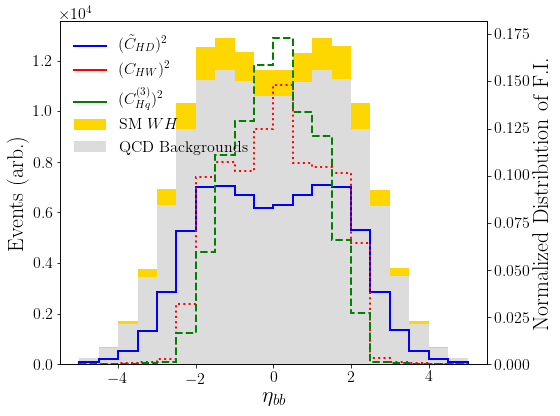

In [45]:
d62_distribution_plot(bins_histo_wph_mu_etah_d62, 'eta_h', r'$\eta_{bb}$', fi_histo_etah_d62_rot, 'd62_info_dist_etah', log_y_axis=False, legend_loc='upper left')

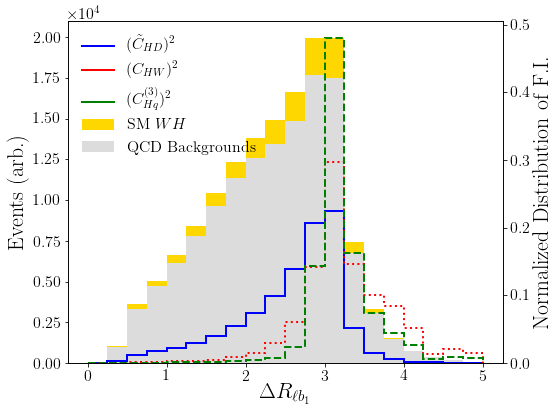

In [46]:
d62_distribution_plot(bins_histo_wph_mu_drlb1_d62, 'dR_lb1', r'$\Delta R_{\ell b_1}$', fi_histo_drlb1_d62_rot, 'd62_info_dist_drlb1', log_y_axis=False, legend_loc='upper left')

## Linear and Squared Distributions on the Same Axis

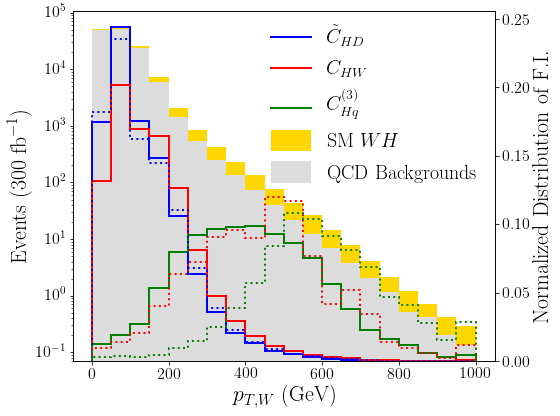

In [47]:
observable = 'pt_w'

bins = bins_histo_wph_mu_ptw
fi_list = fi_histo_ptw_rot
fi_list_d62 = fi_histo_ptw_d62_rot

xlabel = r'$p_{T,W}$ (GeV)'
log_y_axis=True
include_legend=True
legend_loc='upper right'
my_xrange=None
outfilename = None 
    
#bins_ptw = bins_histo_wph_mu_ptw
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
ax1.set_xlim(my_xrange)
    

ax1.hist(
    [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
    weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
#    [ x_weighted_sig[:,index] ],
#    weights = [ weights_sig ],
    bins = bins,
    range = thisrange,
    histtype='stepfilled',
    stacked=True,
    color=[color_bkg, color_sig],
#    color=[ color_sig ],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    ax2.legend(handles=legend_elements, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

#    ax2.legend(handles=legend_elements, loc=legend_loc, fontsize=16, frameon=False)
    
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.5, r'Info on $C_i^2/\Lambda^4$ Term', fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.46, 'assuming no SM-BSM',fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.40, 'interference',fontsize=16)
        
plt.tight_layout()
plt.savefig('plots/info_dist_ptw_comb.pdf')
plt.show()

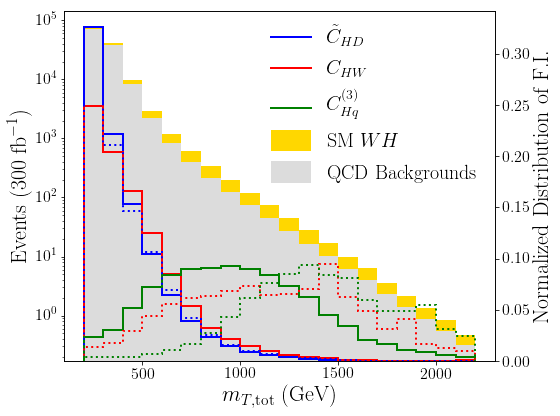

In [48]:
observable = 'mt_tot'

bins = bins_histo_wph_mu_mttot
fi_list = fi_histo_mttot_rot
fi_list_d62 = fi_histo_mttot_d62_rot

xlabel = r'$m_{T,\mathrm{tot}}$ (GeV)'
log_y_axis=True
include_legend=True
legend_loc='upper right'
my_xrange=None
outfilename = None 
    
#bins_mttot = bins_histo_wph_mu_mttot
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
ax1.set_xlim(my_xrange)
    

ax1.hist(
    [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
    weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
#    [ x_weighted_sig[:,index] ],
#    weights = [ weights_sig ],
    bins = bins,
    range = thisrange,
    histtype='stepfilled',
    stacked=True,
    color=[color_bkg, color_sig],
#    color=[ color_sig ],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    ax2.legend(handles=legend_elements, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

#    ax2.legend(handles=legend_elements, loc=legend_loc, fontsize=16, frameon=False)
    
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.5, r'Info on $C_i^2/\Lambda^4$ Term', fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.46, 'assuming no SM-BSM',fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.40, 'interference',fontsize=16)
        
plt.tight_layout()
plt.savefig('plots/info_dist_mttot_comb.pdf')
plt.show()

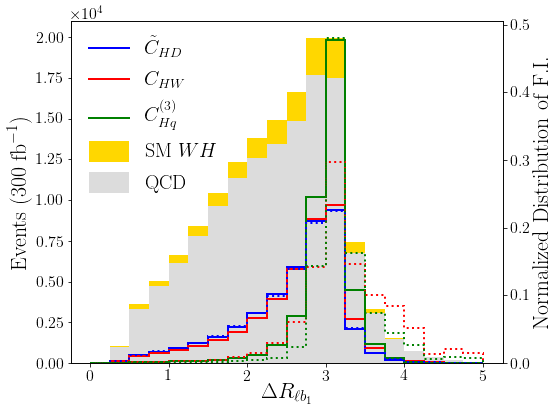

In [49]:
observable = 'dR_lb1'

bins = bins_histo_wph_mu_drlb1
fi_list = fi_histo_drlb1_rot
fi_list_d62 = fi_histo_drlb1_d62_rot

xlabel = r'$\Delta R_{\ell b_1}$'
log_y_axis=False
include_legend=True
legend_loc='upper left'
my_xrange=None
outfilename = None 
    
#bins_drlb1 = bins_histo_wph_mu_drlb1
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
ax1.set_xlim(my_xrange)
    

ax1.hist(
    [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
    weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
#    [ x_weighted_sig[:,index] ],
#    weights = [ weights_sig ],
    bins = bins,
    range = thisrange,
    histtype='stepfilled',
    stacked=True,
    color=[color_bkg, color_sig],
#    color=[ color_sig ],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    ax2.legend(handles=legend_elements_short, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

#    ax2.legend(handles=legend_elements, loc=legend_loc, fontsize=16, frameon=False)
    
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.5, r'Info on $C_i^2/\Lambda^4$ Term', fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.46, 'assuming no SM-BSM',fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.40, 'interference',fontsize=16)
        
plt.tight_layout()
plt.savefig('plots/info_dist_drlb1_comb.pdf')
plt.show()

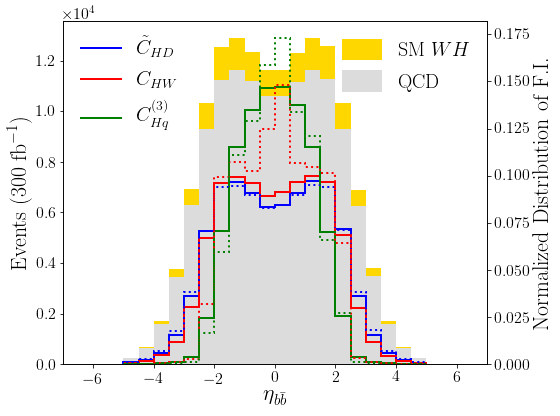

In [50]:
observable = 'eta_h'

bins = bins_histo_wph_mu_etah
fi_list = fi_histo_etah_rot
fi_list_d62 = fi_histo_etah_d62_rot

xlabel = r'$\eta_{b\bar{b}}$'
log_y_axis=False
include_legend=True
legend_loc='upper left'
my_xrange=None
outfilename = None 
    
#bins_etah = bins_histo_wph_mu_etah
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))
    
ax1.set_xlim(my_xrange)   

ax1.hist(
    [ x_weighted_bkg[:,index], x_weighted_sig[:,index] ],
    weights = [ 300.*1000.*weights_bkg, 300.*1000.*weights_sig ],
#    [ x_weighted_sig[:,index] ],
#    weights = [ weights_sig ],
    bins = bins,
    range = thisrange,
    histtype='stepfilled',
    stacked=True,
    color=[color_bkg, color_sig],
#    color=[ color_sig ],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    #ax2.legend(handles=legend_elements_short, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)
    ax1.legend(handles=legend_elements_split1, loc='upper left', ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)
    ax2.legend(handles=legend_elements_split2, loc='upper right', ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)
#    ax2.legend(handles=legend_elements, loc=legend_loc, fontsize=16, frameon=False)
    
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.5, r'Info on $C_i^2/\Lambda^4$ Term', fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.46, 'assuming no SM-BSM',fontsize=16)
#plt.text(ax2.get_xlim()[1]*0.6,ax2.get_ylim()[1]*0.40, 'interference',fontsize=16)
        
ax1.set_xlim(-7,7)
ax2.set_xlim(-7,7)

plt.tight_layout()
plt.savefig('plots/info_dist_etah_comb.pdf')
plt.show()

## Signal Only Plots

In [27]:
legend_elements_sig = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls='-',
           label=r'$\tilde{C}_{HD}$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls='-',
           label=r'$C_{HW}$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls='-',
           label=r'$C_{Hq}^{(3)}$'),
        Patch(facecolor=color_sig, label='SM Signal'),
#        Patch(facecolor=color_bkg, label='Background')
    ]

In [28]:
legend_elements_d62_sig = [
        Line2D([0],[0],color=fi_dist_color1, lw=fi_dist_linewidth,ls=fi_dist_linestyle1,
           label=r'$(\tilde{C}_{HD})^2$'),
        Line2D([0],[0],color=fi_dist_color2, lw=fi_dist_linewidth,ls=fi_dist_linestyle2,
           label=r'$(C_{HW})^2$'),
        Line2D([0],[0],color=fi_dist_color3, lw=fi_dist_linewidth,ls=fi_dist_linestyle3,
           label=r'$(C_{Hq}^{(3)})^2$'),
        Patch(facecolor=color_sig, label='SM Signal'),
#        Patch(facecolor=color_bkg, label='Background')
    ]

### Normal (Linearized)

#### Kinematic Only

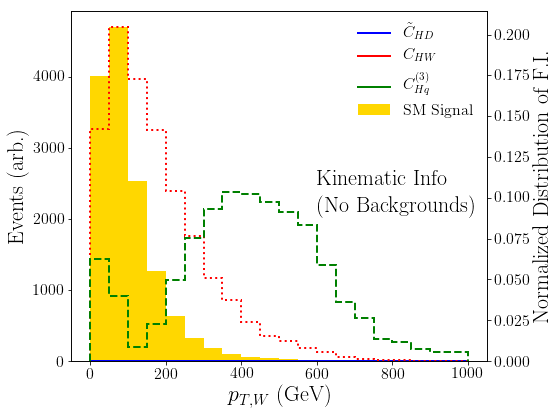

In [53]:
bins_ptw = bins_histo_wph_mu_nobkgs_ptw
xvals = [ (bins_ptw[i] + bins_ptw[i+1]) / 2 for i in range(0, len(bins_ptw) - 1)]
xvals = [ bins_ptw[0] - 1e-9 ] + xvals + [bins_ptw[len(bins_ptw) - 1] + 1e-9]
thisrange = (bins_ptw[0], bins_ptw[-1])

ptw_index = sa_bkgs_wph_mu.observables.keys().index('pt_w')
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
ax1.set_xlabel(r'$p_{T,W}$ (GeV)', color='black',fontsize=22)

ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

#ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = 1.
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_rot]) - sum([fi[1,1] for fi in fi_histo_rate_nobkgs_ptw_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_rot]) - sum([fi[2,2] for fi in fi_histo_rate_nobkgs_ptw_rot])

ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*(fi_histo_nobkgs_ptw_rot[i][0,0] - fi_histo_rate_nobkgs_ptw_rot[i][0,0]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle1,
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*(fi_histo_nobkgs_ptw_rot[i][1,1] - fi_histo_rate_nobkgs_ptw_rot[i][1,1]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle2,
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*(fi_histo_nobkgs_ptw_rot[i][2,2] - fi_histo_rate_nobkgs_ptw_rot[i][2,2]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle3,
    label=r'$c_{Hq}^{(3)}$'
)

ax2.legend(handles=legend_elements_sig, loc='upper right',fontsize=16,frameon=False)

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

plt.text(600,ax2.get_ylim()[1]*0.50, r'Kinematic Info',fontsize=22)
plt.text(600,ax2.get_ylim()[1]*0.425, r'(No Backgrounds)',fontsize=22)

plt.tight_layout()
plt.savefig('plots/dists/info_dist_nobkgs_ptw_kinematic.pdf')
plt.show()

#### Full Info

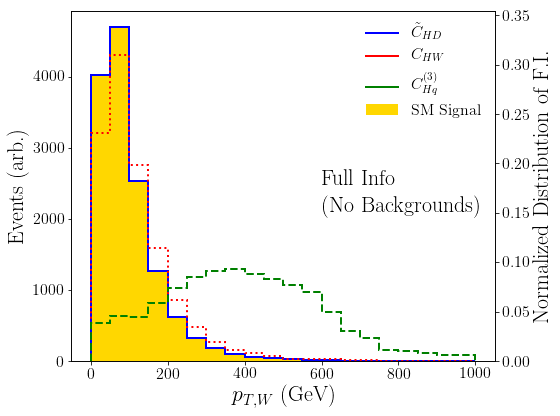

In [54]:
bins_ptw = bins_histo_wph_mu_nobkgs_ptw
xvals = [ (bins_ptw[i] + bins_ptw[i+1]) / 2 for i in range(0, len(bins_ptw) - 1)]
xvals = [ bins_ptw[0] - 1e-9 ] + xvals + [bins_ptw[len(bins_ptw) - 1] + 1e-9]
thisrange = (bins_ptw[0], bins_ptw[-1])

ptw_index = sa_bkgs_wph_mu.observables.keys().index('pt_w')
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
ax1.set_xlabel(r'$p_{T,W}$ (GeV)', color='black',fontsize=22)

ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

#ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_histo_nobkgs_ptw_rot])
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_rot])

ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_histo_nobkgs_ptw_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle1,
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_histo_nobkgs_ptw_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle2,
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_histo_nobkgs_ptw_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle3,
    label=r'$c_{Hq}^{(3)}$'
)

ax2.legend(handles=legend_elements_sig, loc='upper right',fontsize=16,frameon=False)

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

plt.text(600,ax2.get_ylim()[1]*0.50, r'Full Info',fontsize=22)
plt.text(600,ax2.get_ylim()[1]*0.425, r'(No Backgrounds)',fontsize=22)

plt.tight_layout()
plt.savefig('plots/dists/info_dist_nobkgs_ptw.pdf')
plt.show()

### d6^2 Plots

#### Kinematic Only

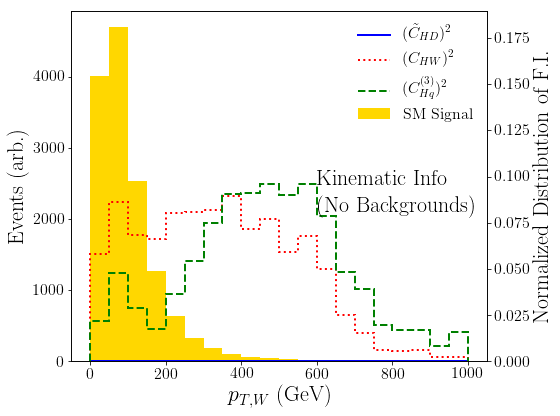

In [55]:
bins_ptw = bins_histo_wph_mu_nobkgs_ptw
xvals = [ (bins_ptw[i] + bins_ptw[i+1]) / 2 for i in range(0, len(bins_ptw) - 1)]
xvals = [ bins_ptw[0] - 1e-9 ] + xvals + [bins_ptw[len(bins_ptw) - 1] + 1e-9]
thisrange = (bins_ptw[0], bins_ptw[-1])

ptw_index = sa_bkgs_wph_mu.observables.keys().index('pt_w')
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
ax1.set_xlabel(r'$p_{T,W}$ (GeV)', color='black',fontsize=22)

ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

#ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)
ax2.set_ylim(0.,0.19)

fi1_norm = 1.
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_d62_rot]) - sum([fi[1,1] for fi in fi_histo_rate_nobkgs_ptw_d62_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_d62_rot]) - sum([fi[2,2] for fi in fi_histo_rate_nobkgs_ptw_d62_rot])

ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][0,0] - fi_histo_rate_nobkgs_ptw_d62_rot[i][0,0]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle1,
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][1,1] - fi_histo_rate_nobkgs_ptw_d62_rot[i][1,1]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle2,
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][2,2] - fi_histo_rate_nobkgs_ptw_d62_rot[i][2,2]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle3,
    label=r'$c_{Hq}^{(3)}$'
)

ax2.legend(handles=legend_elements_d62_sig, loc='upper right',fontsize=16,frameon=False)

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

plt.text(600,ax2.get_ylim()[1]*0.50, r'Kinematic Info',fontsize=22)
plt.text(600,ax2.get_ylim()[1]*0.425, r'(No Backgrounds)',fontsize=22)

plt.tight_layout()
plt.savefig('dim6_squared_results/plots/dists/d62_info_dist_nobkgs_ptw_kinematic.pdf')
plt.show()

#### Full Info

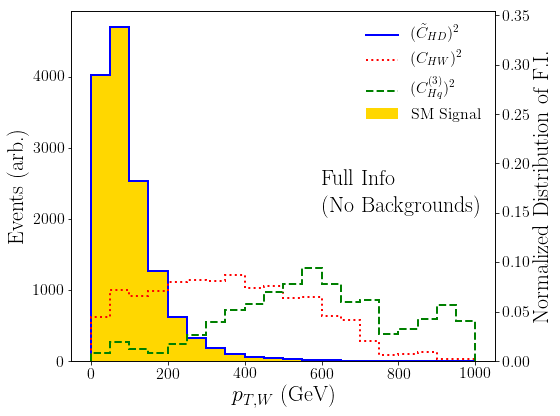

In [56]:
bins_ptw = bins_histo_wph_mu_nobkgs_ptw
xvals = [ (bins_ptw[i] + bins_ptw[i+1]) / 2 for i in range(0, len(bins_ptw) - 1)]
xvals = [ bins_ptw[0] - 1e-9 ] + xvals + [bins_ptw[len(bins_ptw) - 1] + 1e-9]
thisrange = (bins_ptw[0], bins_ptw[-1])

ptw_index = sa_bkgs_wph_mu.observables.keys().index('pt_w')
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events (arb.)', color='black',fontsize=22)
ax1.set_xlabel(r'$p_{T,W}$ (GeV)', color='black',fontsize=22)

ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

#ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_histo_nobkgs_ptw_d62_rot])
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_d62_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_d62_rot])

ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_histo_nobkgs_ptw_d62_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle1,
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_histo_nobkgs_ptw_d62_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle2,
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_histo_nobkgs_ptw_d62_rot ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = fi_dist_linestyle3,
    label=r'$c_{Hq}^{(3)}$'
)

ax2.legend(handles=legend_elements_d62_sig, loc='upper right',fontsize=16,frameon=False)

ax1.ticklabel_format(axis='y', style='sci', scilimits=(-4,4))

plt.text(600,ax2.get_ylim()[1]*0.50, r'Full Info',fontsize=22)
plt.text(600,ax2.get_ylim()[1]*0.425, r'(No Backgrounds)',fontsize=22)

plt.tight_layout()
plt.savefig('dim6_squared_results/plots/dists/d62_info_dist_nobkgs_ptw.pdf')
plt.show()

## Signal Only: Linear & Squared on the Same Axis

### Kinematic Only

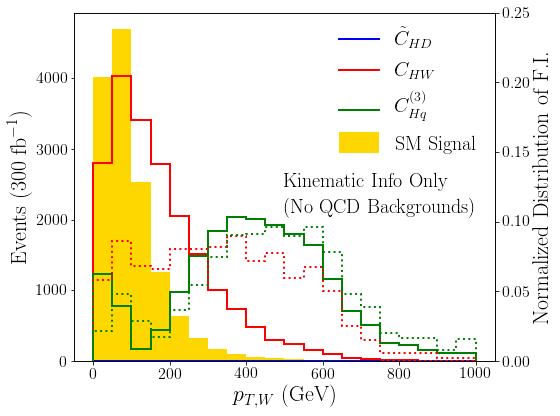

In [60]:
observable = 'pt_w'

bins = bins_histo_wph_mu_ptw
fi_list = fi_histo_nobkgs_ptw_rot
fi_list_d62 = fi_histo_nobkgs_ptw_d62_rot

xlabel = r'$p_{T,W}$ (GeV)'
log_y_axis=False
include_legend=True
legend_loc='upper right'
my_xrange=None
outfilename = None 
    
#bins_ptw = bins_histo_wph_mu_ptw
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
ax1.set_xlim(my_xrange)
    
ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

#fi1_norm = sum([fi[0,0] for fi in fi_list])
#fi2_norm = sum([fi[1,1] for fi in fi_list])
#fi3_norm = sum([fi[2,2] for fi in fi_list])
    
#fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
#fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
#fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
fi1_norm = 1.
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_rot]) - sum([fi[1,1] for fi in fi_histo_rate_nobkgs_ptw_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_rot]) - sum([fi[2,2] for fi in fi_histo_rate_nobkgs_ptw_rot])

ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*(fi_histo_nobkgs_ptw_rot[i][0,0] - fi_histo_rate_nobkgs_ptw_rot[i][0,0]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*(fi_histo_nobkgs_ptw_rot[i][1,1] - fi_histo_rate_nobkgs_ptw_rot[i][1,1]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*(fi_histo_nobkgs_ptw_rot[i][2,2] - fi_histo_rate_nobkgs_ptw_rot[i][2,2]) for i in range(len(fi_histo_nobkgs_ptw_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)


fi1_norm = 1.
fi2_norm = sum([fi[1,1] for fi in fi_histo_nobkgs_ptw_d62_rot]) - sum([fi[1,1] for fi in fi_histo_rate_nobkgs_ptw_d62_rot])
fi3_norm = sum([fi[2,2] for fi in fi_histo_nobkgs_ptw_d62_rot]) - sum([fi[2,2] for fi in fi_histo_rate_nobkgs_ptw_d62_rot])

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][0,0] - fi_histo_rate_nobkgs_ptw_d62_rot[i][0,0]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][1,1] - fi_histo_rate_nobkgs_ptw_d62_rot[i][1,1]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*(fi_histo_nobkgs_ptw_d62_rot[i][2,2] - fi_histo_rate_nobkgs_ptw_d62_rot[i][2,2]) for i in range(len(fi_histo_nobkgs_ptw_d62_rot)) ],
    bins = bins_ptw,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

ax2.set_ylim(0.,0.25)

if include_legend:
    ax2.legend(handles=legend_elements_sig, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

plt.text(500,ax2.get_ylim()[1]*0.50, r'Kinematic Info Only',fontsize=20)
plt.text(500,ax2.get_ylim()[1]*0.425, r'(No QCD Backgrounds)',fontsize=20)
        
plt.tight_layout()
plt.savefig('plots/info_dist_nobkgs_ptw_kinematic_comb.pdf')
plt.show()

### Full Info

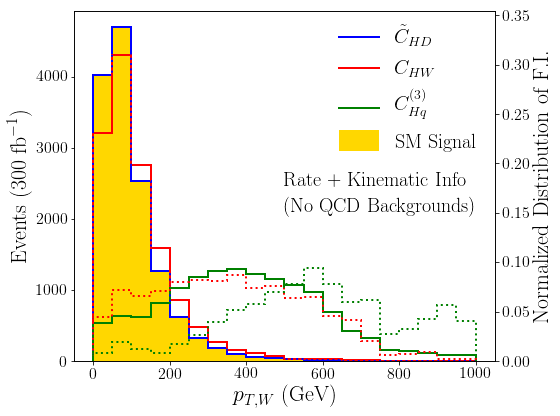

In [58]:
observable = 'pt_w'

bins = bins_histo_wph_mu_ptw
fi_list = fi_histo_nobkgs_ptw_rot
fi_list_d62 = fi_histo_nobkgs_ptw_d62_rot

xlabel = r'$p_{T,W}$ (GeV)'
log_y_axis=False
include_legend=True
legend_loc='upper right'
my_xrange=None
outfilename = None 
    
#bins_ptw = bins_histo_wph_mu_ptw
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
ax1.set_xlim(my_xrange)
    
ax1.hist(
    [ x_weighted_sig[:,ptw_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_ptw,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    ax2.legend(handles=legend_elements_sig, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

plt.text(500,ax2.get_ylim()[1]*0.50, r'Rate + Kinematic Info',fontsize=20)
plt.text(500,ax2.get_ylim()[1]*0.425, r'(No QCD Backgrounds)',fontsize=20)
        
plt.tight_layout()
plt.savefig('plots/info_dist_nobkgs_ptw_comb.pdf')
plt.show()

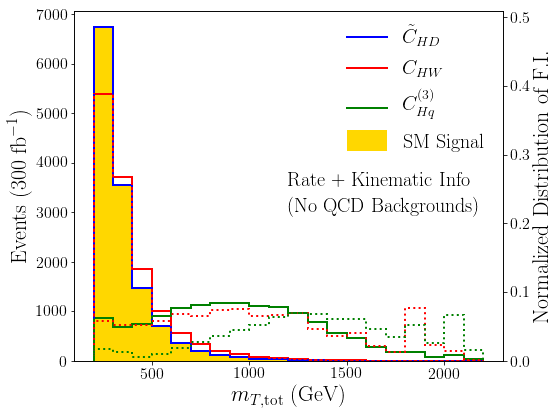

In [32]:
observable = 'mt_tot'

bins_mttot = bins_histo_wph_mu_nobkgs_mttot
fi_list = fi_histo_nobkgs_mttot_rot
fi_list_d62 = fi_histo_nobkgs_mttot_d62_rot

xlabel = r'$m_{T,\mathrm{tot}}$ (GeV)'
log_y_axis=False
include_legend=True
legend_loc='upper right'
my_xrange=None
outfilename = None 

mttot_index = sa_bkgs_wph_mu.observables.keys().index('mt_tot')
    
#bins_mttot = bins_histo_wph_mu_mttot
xvals = [ (bins[i] + bins[i+1]) / 2 for i in range(0, len(bins) - 1)]
xvals = [ bins[0] - 1e-9 ] + xvals + [bins[len(bins) - 1] + 1e-9]
    
if my_xrange is not None:
    thisrange = my_xrange
else:
    thisrange = (bins[0], bins[-1])

index = sa_bkgs_wph_mu.observables.keys().index(observable)
#x_weighted_bkg[:,thisindex]

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)
fig.subplots_adjust(left=0.1667, right=0.8333, bottom=0.17, top=0.97)

ax1.set_ylabel('Events ($300~\mathrm{fb}^{-1}$)', color='black',fontsize=22)
ax1.set_xlabel(xlabel, color='black',fontsize=22)
    
ax1.set_xlim(my_xrange)
    
ax1.hist(
    [ x_weighted_sig[:,mttot_index] ],
    weights = [ 300.*1000.*weights_sig ],
    bins = bins_mttot,
    histtype='stepfilled',
    stacked=True,
    color=[color_sig],
    alpha=1.0
)

if log_y_axis:
    ax1.set_yscale('log')

## Second Axis for F.I.

ax2 = ax1.twinx()
ax2.set_ylabel(r'Normalized Distribution of F.I.', color='black',fontsize=22)

fi1_norm = sum([fi[0,0] for fi in fi_list])
fi2_norm = sum([fi[1,1] for fi in fi_list])
fi3_norm = sum([fi[2,2] for fi in fi_list])
    
fi1_norm_d62 = sum([fi[0,0] for fi in fi_list_d62])
fi2_norm_d62 = sum([fi[1,1] for fi in fi_list_d62])
fi3_norm_d62 = sum([fi[2,2] for fi in fi_list_d62])
    
# Normal Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm)*fi[0,0] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm)*fi[1,1] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{HW}^{\phantom{(3)}}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm)*fi[2,2] for fi in fi_list ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'solid',
    label=r'$c_{Hq}^{(3)}$'
)

# Dim6^2 Distributions
ax2.hist(
    xvals,
    weights = [ 1./(fi1_norm_d62)*fi[0,0] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color1,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{H\boxdot} - \frac{1}{4}c_{HD}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi2_norm_d62)*fi[1,1] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color2,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{HW}$'
)

ax2.hist(
    xvals,
    weights = [ 1./(fi3_norm_d62)*fi[2,2] for fi in fi_list_d62 ],
    bins = bins,
    range = thisrange,
    histtype = 'step',
    color = fi_dist_color3,
    linewidth = fi_dist_linewidth,
    linestyle = 'dotted',
    label=r'$c_{Hq}^{(3)}$'
)

if include_legend:
    ax2.legend(handles=legend_elements_sig, loc=legend_loc, ncol=1, frameon=False, fontsize=20, labelspacing=0.5, handleheight=1.25)

plt.text(1200,ax2.get_ylim()[1]*0.50, r'Rate + Kinematic Info',fontsize=20)
plt.text(1200,ax2.get_ylim()[1]*0.425, r'(No QCD Backgrounds)',fontsize=20)
        
plt.tight_layout()
plt.savefig('plots/info_dist_nobkgs_mttot_comb.pdf')
plt.show()